In [57]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
OP_FIL_DIR = "output"

In [59]:
def load_data(file_name):
    with open(f'{OP_FIL_DIR}/{file_name}.pkl', 'rb') as f:
        loaded_data = pickle.load(f)
    return loaded_data

def per_iter_speedup(row, sequential_times):
    if row['algo_name'] == 'sequential':
        return 1
    else:
        time_value = sequential_times[(sequential_times['file_name'] == row['file_name']) & (sequential_times['num_threads'] == row['num_threads'])]['main_per_iteration'].values
        return time_value[0]/row['per_iteration']
    
def overall_speedup(row, sequential_times):
    if row['algo_name'] == 'sequential':
        return 1
    else:
        time_value = sequential_times[(sequential_times['file_name'] == row['file_name']) & (sequential_times['num_threads'] == row['num_threads'])]['main_total'].values
        return time_value[0]/row['elapsed_time']

def calculate_speed_up(df):
    sequential_times = df[df['algo_name'] == 'sequential']
    df['speed_up_per_iteration'] = df.apply(lambda row: per_iter_speedup(row, sequential_times), axis=1)
    df['overall_speedup'] = df.apply(lambda row: overall_speedup(row, sequential_times), axis=1)
    return df

def load_df(file_name):
    data = load_data(file_name)
    df = pd.DataFrame(data)
    return calculate_speed_up(df)

def avg_trials(df1, df2, df3):
    df_all = pd.concat([df1, df2, df3])
    df_avg = df_all.groupby(['algo_name', 'file_name', 'num_threads']).mean().reset_index()
    df_avg = df_avg[['algo_name', 'file_name', 'num_threads', 'main_per_iteration', 'main_total', 'per_iteration', 'elapsed_time', 'percent_spent_in_io']]
    df_avg = df_avg.round(6)
    return df_avg

def plot_graph(df, column_name):
    plt.figure(figsize=(10, 6))
    sns.set(style="whitegrid")
    sns.barplot(x='file_name', y=column_name, hue='algo_name', data=df)
    plt.title(f'{column_name} Comparison Across Files and Algorithms', fontsize=16)
    plt.xlabel('file_name', fontsize=12)
    plt.ylabel(f'{column_name}', fontsize=12)

    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()


def plot_graphs(df, column_name):
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    sns.set(style="whitegrid")

    algo_order = ['sequential', 'cuda', 'cuda_shared_mem', 'thrust']

    # Plot for num_threads = 512
    sns.barplot(x='file_name', y=column_name, hue='algo_name', hue_order=algo_order, data=df[df['num_threads'] == 512], ax=axes[0])
    axes[0].set_title(f'{column_name} Comparison for num_threads=512', fontsize=16)
    axes[0].set_xlabel('file_name', fontsize=12)
    axes[0].set_ylabel(column_name, fontsize=12)
    axes[0].tick_params(axis='x', rotation=45)

    # Plot for num_threads = 1024
    sns.barplot(x='file_name', y=column_name, hue='algo_name', hue_order=algo_order, data=df[df['num_threads'] == 1024], ax=axes[1])
    axes[1].set_title(f'{column_name} Comparison for num_threads=1024', fontsize=16)
    axes[1].set_xlabel('file_name', fontsize=12)
    axes[1].set_ylabel(column_name, fontsize=12)
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

In [60]:
#loading results from 3 trials
df1 = load_df("all_results_0")
df2 = load_df("all_results_1")
df3 = load_df("all_results_2")
df_avg = avg_trials(df1, df2, df3)
df_avg = calculate_speed_up(df_avg)

In [61]:
df_avg.head()

,algo_name,file_name,num_threads,main_per_iteration,main_total,per_iteration,elapsed_time,percent_spent_in_io,speed_up_per_iteration,overall_speedup
0,cuda,random-n16384-d24-c16,512,0.596941,90.138047,0.135927,20.524982,0.036223,14.072561,3.541438
1,cuda,random-n16384-d24-c16,1024,0.473958,71.567626,0.139295,21.033483,0.033013,16.801931,4.228313
2,cuda,random-n2048-d16-c16,512,3.263482,58.742674,0.068526,1.233461,0.079913,2.941672,2.941691
3,cuda,random-n2048-d16-c16,1024,3.743442,55.704832,0.071165,1.113952,0.082513,2.263051,2.602352
4,cuda,random-n65536-d32-c16,512,1.084163,163.708576,0.546113,82.463051,0.039320,21.282059,11.416205


### GPU Hardware Details
1. Graphics: Nvidia RTX 4090 24Gb
2. Cores: 16384
3. Clock Speed: 2235Mhz
4. Memory Bandwidth (GB/sec): 1008
5. TDP: 450W

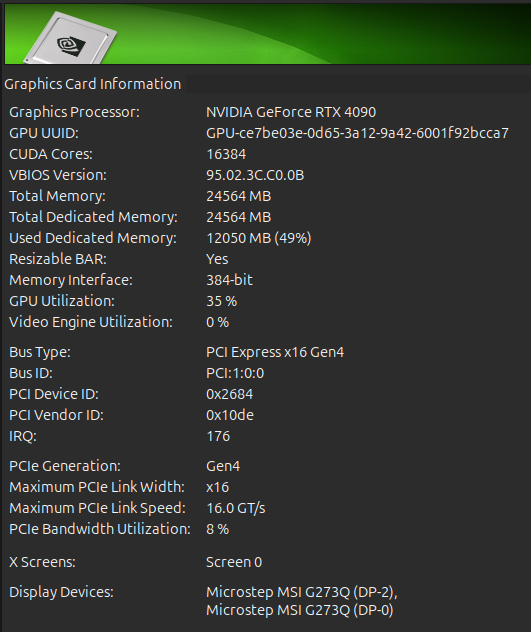

### CPU Hardware Details
1. CPU: 12th Gen Intel® Core™ i9-12900K
2. Cores: 16 (8 performance-cores(5.10 GHz) and 8 efficient-cores(3.90 GHz))
3. Threads: 24
4. Cache: 30MB
5. L2 Cache: 14MB

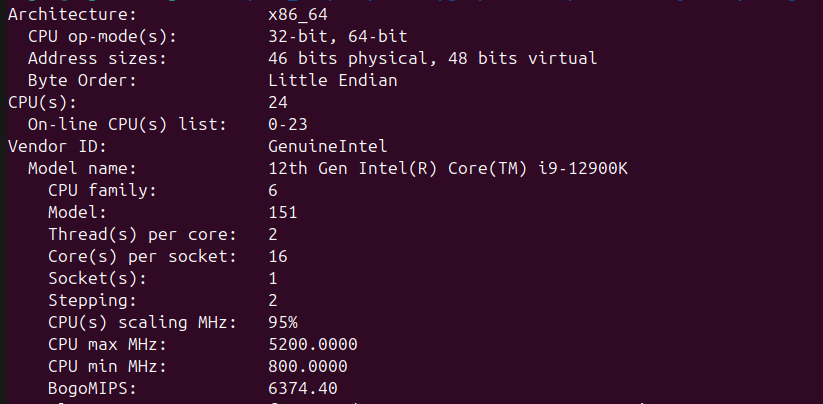

### RAM: 64GB
### OS: Ubuntu 24.04.1 LTS

### Amount of time spend on lab: ~85hrs



## Experiment setting:
1. The python script `run_tests.py` generates the data for the analysis.
2. Standard approach: It uses centroid floating point calculation in convergence check using the provided threshold.
3. Alternate approach: It avoids floating point operations in convergence criteria by comparing the changes in the assignment of points to clusters.
4. For each of the above approaches, I ran *3 trials* of sequential, CUDA basic, CUDA shared memory and thrust with 512 and 1024 thread counts.
5. The results are then averaged - all the graphs presented below are the avg of 3 trails to ensure consistency in output.

The below 2 graphs show the speed up comparison between different parallel implementations for standard approach. 
All graphs related to alternate implementation are presented at the end of the report.

## Speed Up comparison - standard implementation (ms)
### Fastest Implementation
1. For 2k file: The CUDA basic appeared to have the best results for 2k input file in both the cases listed below.
2. For >= 16k files: CUDA with shared memory is the fasted comparatively with a speed up of ~26% in case of 1024 threads.
3. This is inline with my expectations as: 
    * Shared memory reduces latency by caching frequently used centroids, leading to faster access compared to global memory.
    * With larger datasets (n65536), shared memory utilization becomes more effective, as it minimizes global memory access, reducing bottlenecks.
    * For the 2k file though, I had thought sequential would be the fastest but CUDA Basic outperformed the sequential by atleast 2.5x with both number of threads being 512 or 1024.

### Slowest Implementation:
1. For 2k file: Thrust with 1024 threads on 2k dataset, with a speedup of only 0.52x is the lowest parallel implementation. That's lesser than the sequential.
2. For >=16k: CUDA basic underperformed over thrust, the difference is significant with num_threads=1024 as compared to num_threads=512.
3. This is inline with my expectations as: 
    * Thrust is optimized for reduction operations, but in smaller datasets (n2048), the overhead of launching GPU kernels and managing memory can outweigh the benefits of parallelization.
    * Thrust’s memory management may involve more complex overhead than CUDA kernels using shared memory, especially for small datasets.
    * CUDA basic on the other hand, is not as optimized in the memory management and hence as the dataset size increases, we see thrust outperforms the basic CUDA with little to no optimization.

## Speed Up comparison - alternate implementation (ms)
1. After modifying the convergence criteria across all implementations to use the change in assignment of clusters (rather than the distance between old and new centroids falling under a threshold), the results varied significantly. 
2. Specifically, in this alternate implementation, the Thrust-based approach demonstrated much better performance and speedup compared to the standard implementation. The graphs for this alternate approach are presented at the end of the report.
3. The primary reason for the improvement in the alternate implementation is likely due to the difference in the number of comparisons being made. 
4. In the alternate approach, we are comparing the assignments of points to clusters, which involves a significantly higher number of points compared to only the centroids in the standard approach. The Thrust library functions used, particularly for transform_reduce, appear to manage memory more efficiently in this scenario, leading to the observed performance gains.
5. CUDA with shared memory was on par with that of thrust for num_threads=512 but fell behind when num_threads=1024. This is because of increase in global memory accesses in convergence check as I did not implement a shared memory approach for convergence check. In standard implementation, the comparisons were 2*num_clusters*dims but in alternate implementation the num of comparisons were 2*num_points. So as num_points keeps becoming more than num_clusters*dims, thrust keeps gaining advantage over shared memory and basic cuda implementations according to the current version.
6. I believe if I modify the convergence check to use shared_memory as well, may be the results will be different.
7. In this approach, CUDA is the slowest of them all.
8. This clearly shows that the optimization of implementation is equally important aspect of GPU programming to make the best use of GPU.

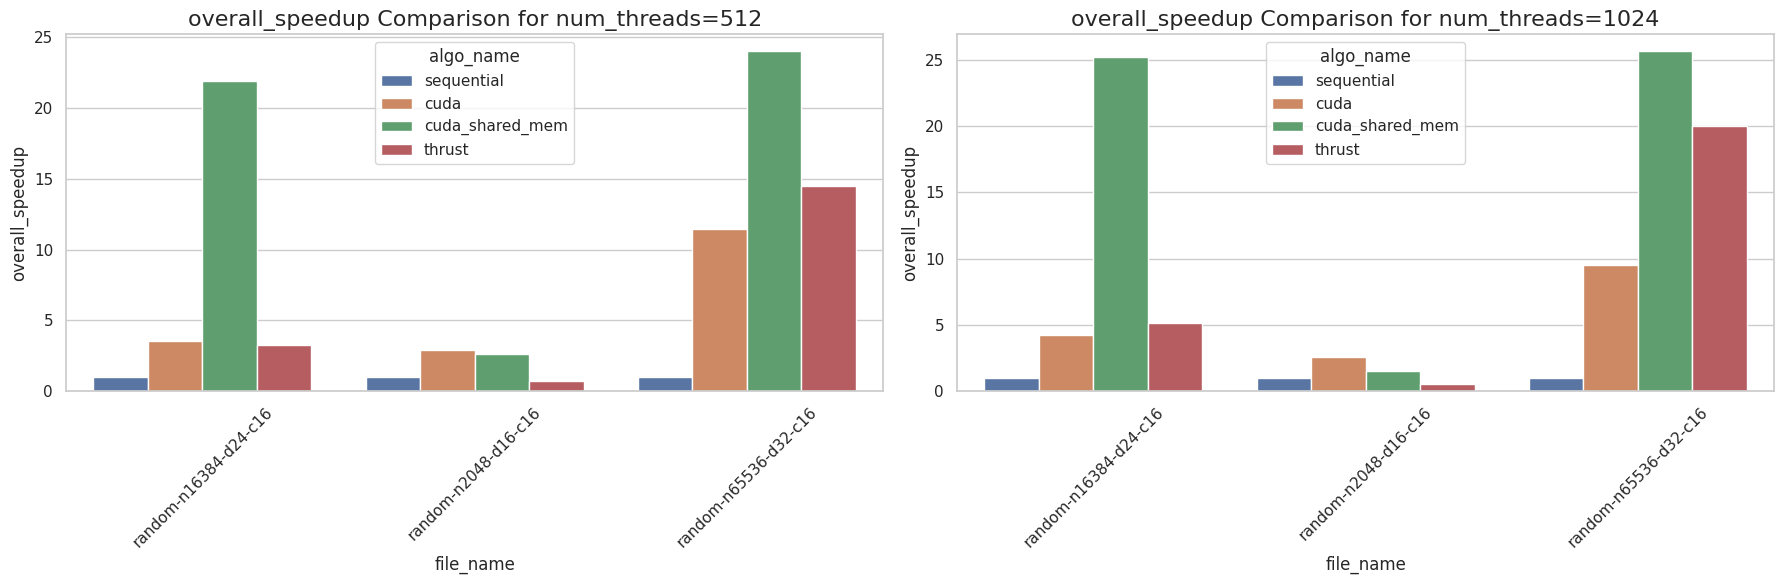

In [62]:
plot_graphs(df_avg, 'overall_speedup')

* Per iteration speedup follow the same as over all speed up except in the case when num_threads=1024. Here thrust appears to outperform the speed up of cuda with shared memory. 
* From my observations, it is because of difference order of floating point error accumulations that is leading to a difference in number of iterations which inturn is effecting the calculation of per_iteration speed up.

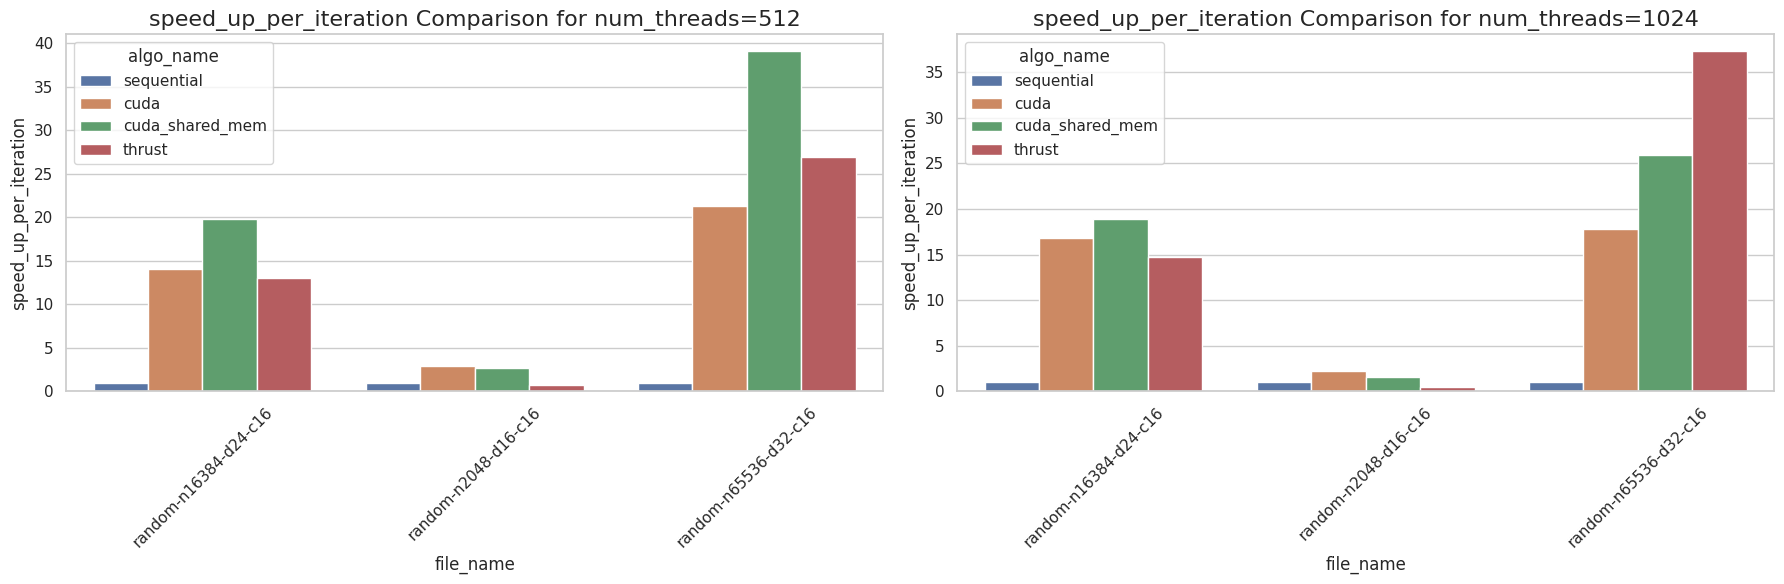

In [63]:
plot_graphs(df_avg, 'speed_up_per_iteration')

## Best-Case Performance Speedup
1. To estimate the theoretical best-case speedup using Amdahl’s Law, we can assume that the parallel portion of the work is distributed evenly across GPU threads. The speedup, S can be modeled as:
```
            S = 1 / ((1 - P) + P /N)
            Where:
                P is the fraction of the program that is parallelizable.
                N is the number of threads or processing units available.
```
2. If we assume 97% of the algorithm is parallelizable (reasonable for K-Means - only during convergence check, copy from device to host is executed), and the GPU I have used has around 16384 cores, the speedup theoretically could approach the following best-case scenario:
```
            S = 1 / ((1 - 0.97) + 0.97 /16384) = ~33
```
3. But the actual speed up in the trials is about x25 on average for shared memory with CUDA implementation. 
4. The actual speed is lower than the theoretical prediction due to:
    * As the number of threads increases, the memory access may become a bottle neck.
    * I could not launch a block with shared memory size as num_points*dims as the dataset kept growing due to limitation on the block memory size which was around ~50000 bytes for my GPU. Due to this reason, I could not efficiently use all the available cores on the GPU.
5. Having said that, the current implementation likely to reach the best case scenario when the number of clusters increase linearly before hitting the max block size.

In [64]:
1 / ((1 - 0.97) + (0.97/16384))

33.26768056204184

## Amount of time spent in IO (%)
1. I've observed that the IO performance in the CUDA implementations can vary significantly, with up to a 20% portion of the end-to-end runtime being spent on data transfer in CUDA with shared memory implementation for 16k dataset. 
2. However, this value is not consistent. In some cases, even for the same implementation, the time spent on IO can fluctuate considerably. 
3. This variability could be due to factors such as the system’s memory bandwidth, contention for shared resources, or even background processes affecting data transfer rates between the CPU and GPU.

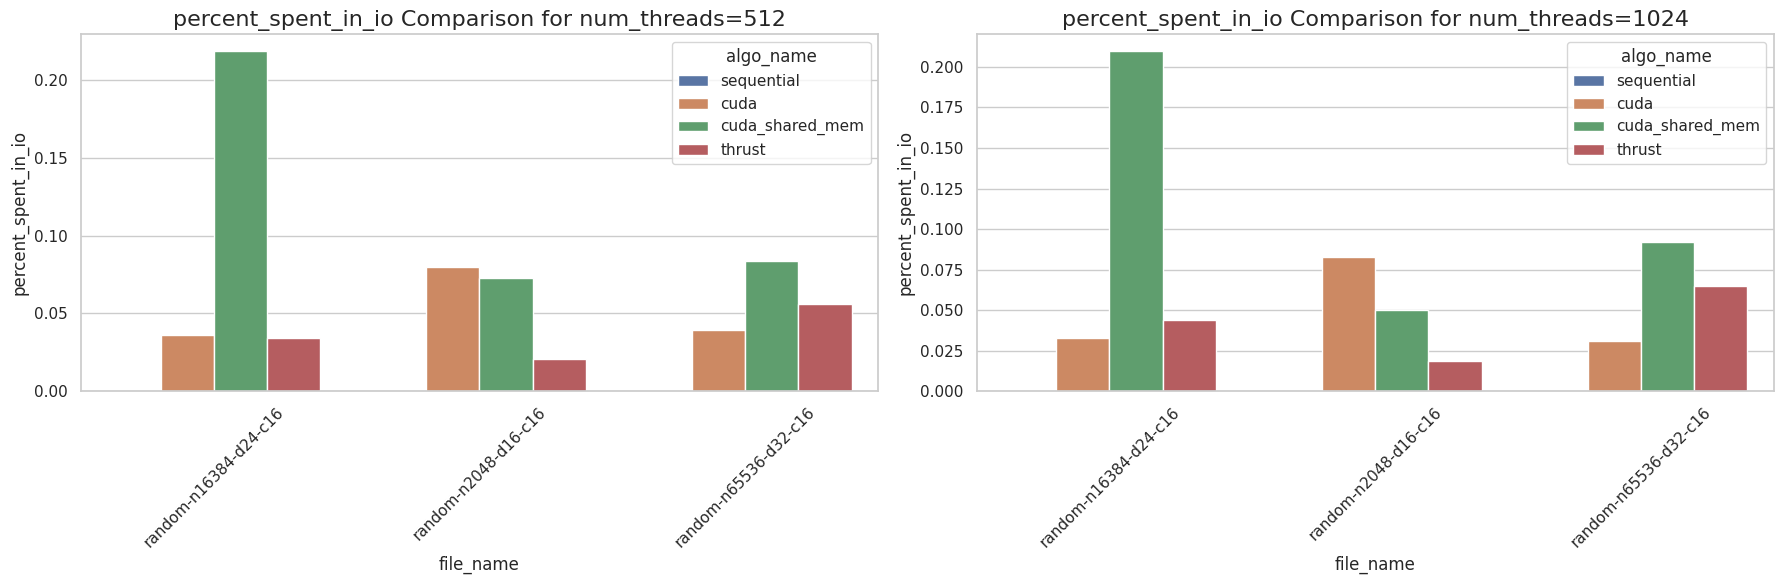

In [65]:
plot_graphs(df_avg, 'percent_spent_in_io')

## Alternate Implementation graphs

In [66]:
#loading results from 3 trials
dff1 = load_df("all_results_f_0")
dff2 = load_df("all_results_f_1")
dff3 = load_df("all_results_f_2")
dff_avg = avg_trials(dff1, dff2, dff3)
dff_avg = calculate_speed_up(dff_avg)

In [67]:
dff_avg.head()

,algo_name,file_name,num_threads,main_per_iteration,main_total,per_iteration,elapsed_time,percent_spent_in_io,speed_up_per_iteration,overall_speedup
0,cuda,random-n16384-d24-c16,512,2.371968,59.079578,0.175211,4.382848,0.165782,12.468949,18.941678
1,cuda,random-n16384-d24-c16,1024,2.290455,54.711241,0.219314,5.302336,0.138383,9.870373,15.513733
2,cuda,random-n2048-d16-c16,512,4.742172,85.359100,0.080735,1.453227,0.074423,2.397225,2.397225
3,cuda,random-n2048-d16-c16,1024,3.050623,54.911204,0.073701,1.326624,0.077325,2.467755,2.467741
4,cuda,random-n65536-d32-c16,512,1.330545,117.680228,0.587472,52.438497,0.061395,18.185040,16.501986


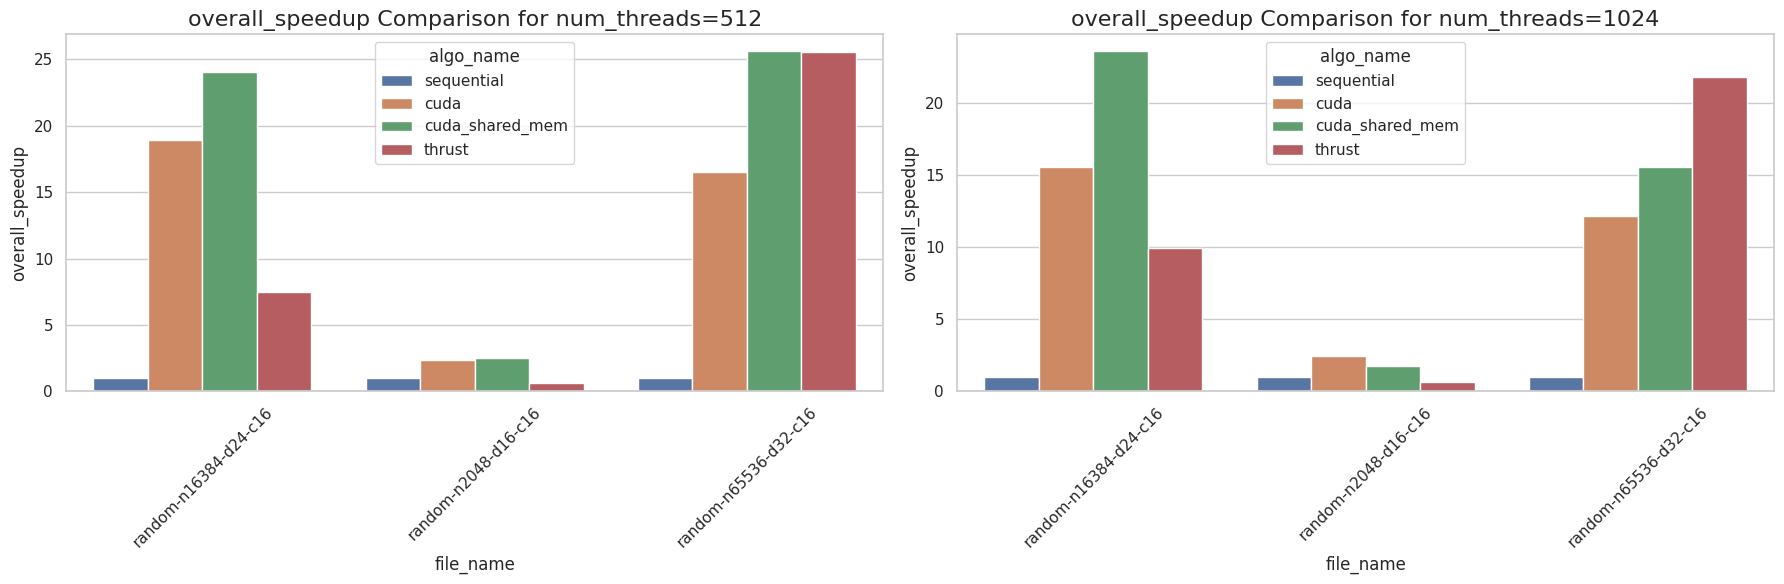

In [68]:
plot_graphs(dff_avg, 'overall_speedup')

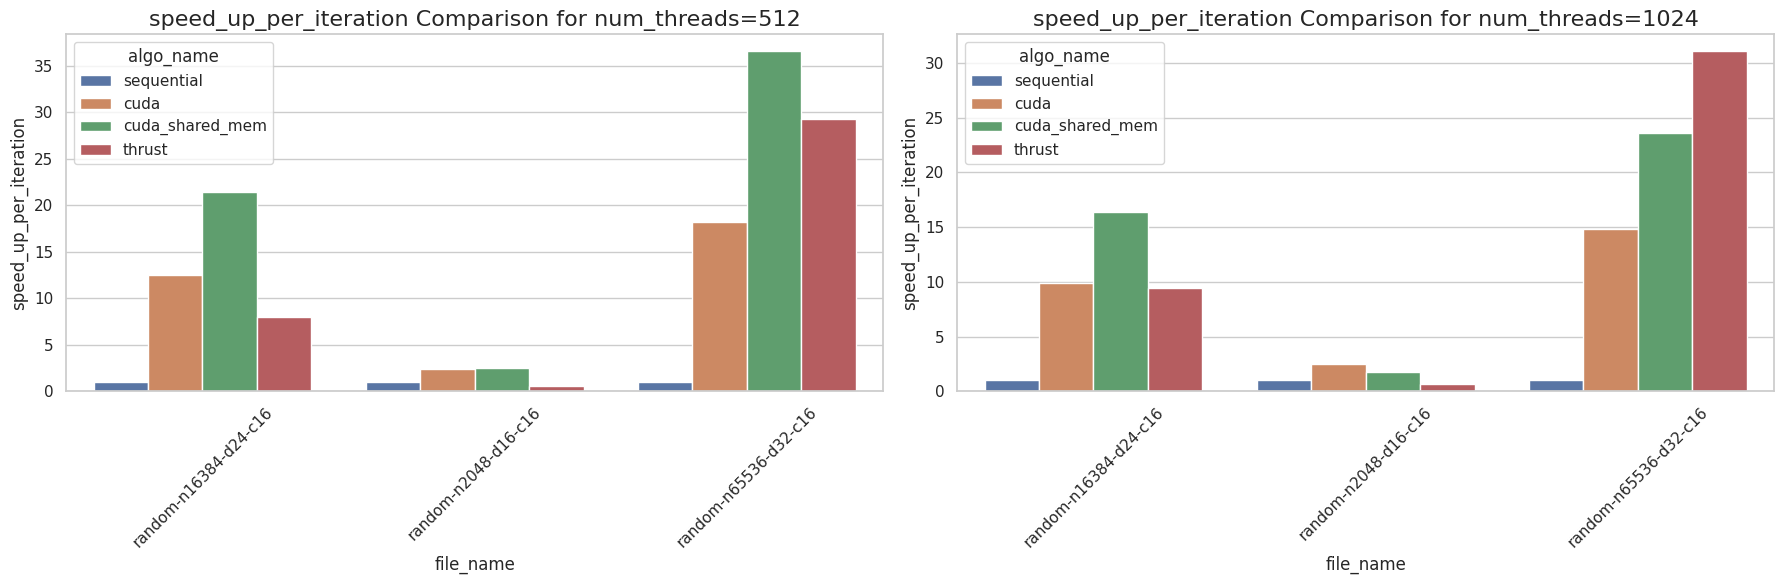

In [69]:
plot_graphs(dff_avg, 'speed_up_per_iteration')

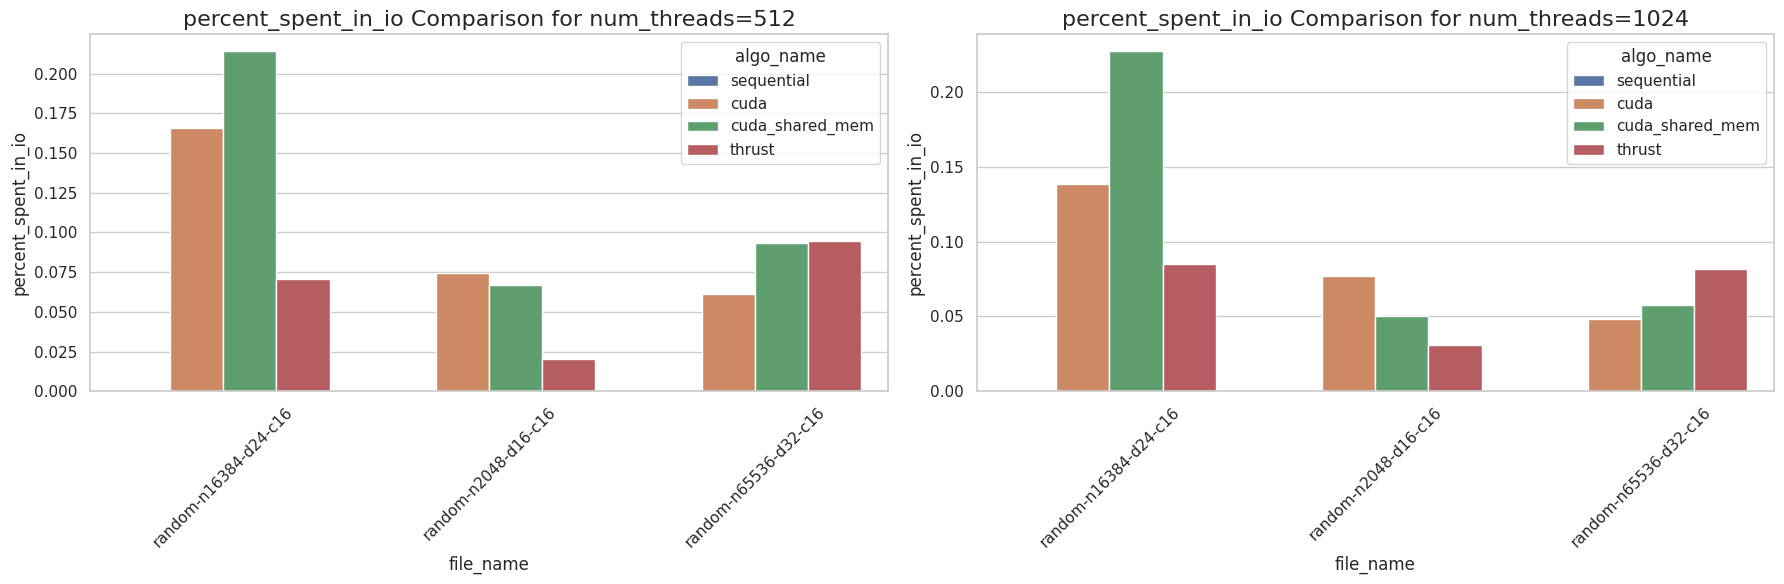

In [70]:
plot_graphs(dff_avg, 'percent_spent_in_io')